## Part 1 : Model Training

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
df  = pd.read_csv("powerconsumption.csv")

In [4]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

In [5]:
chronological_order, equidistant_timestamps


(True, True)

In [6]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [7]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))
    
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)
    
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']
    
    return df.astype(float)

In [8]:
df = df.set_index('Datetime')
df = create_features(df)

In [9]:
df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter', 'season']].head()


,year,month,day,minute,dayofyear,weekofyear,quarter,season
Datetime,,,,,,,,
2017-01-01 00:00:00,2017.0,1.0,1.0,0.0,1.0,52.0,1.0,1.0
2017-01-01 00:10:00,2017.0,1.0,1.0,10.0,1.0,52.0,1.0,1.0
2017-01-01 00:20:00,2017.0,1.0,1.0,20.0,1.0,52.0,1.0,1.0
2017-01-01 00:30:00,2017.0,1.0,1.0,30.0,1.0,52.0,1.0,1.0
2017-01-01 00:40:00,2017.0,1.0,1.0,40.0,1.0,52.0,1.0,1.0


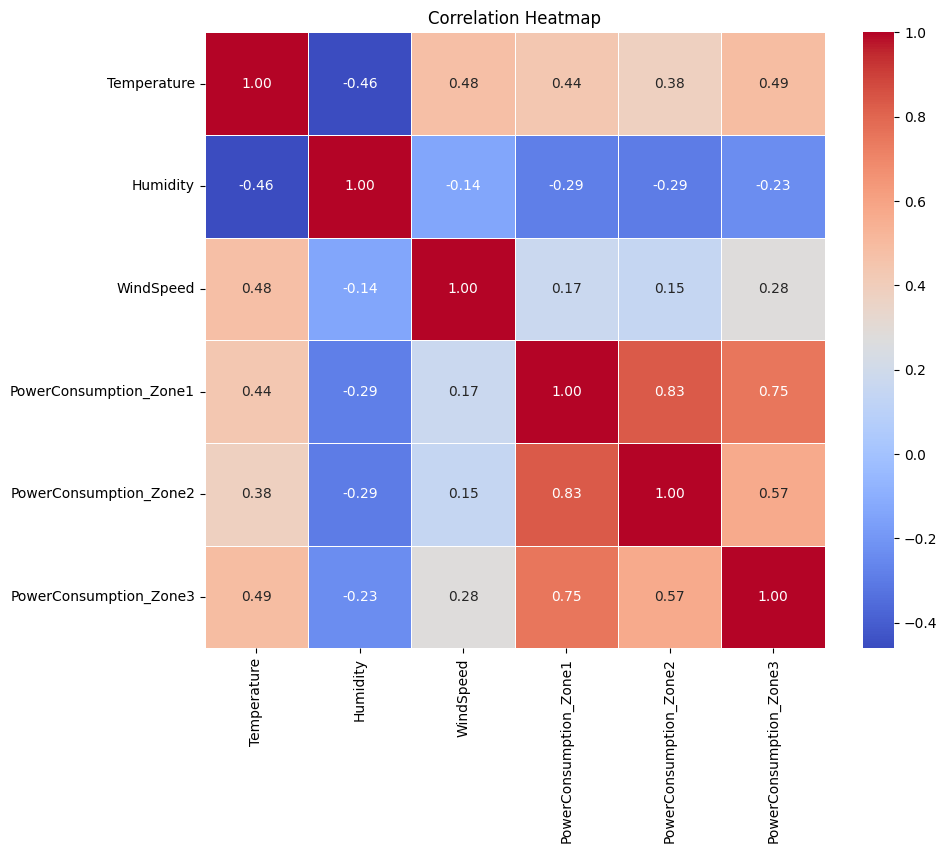

In [10]:
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

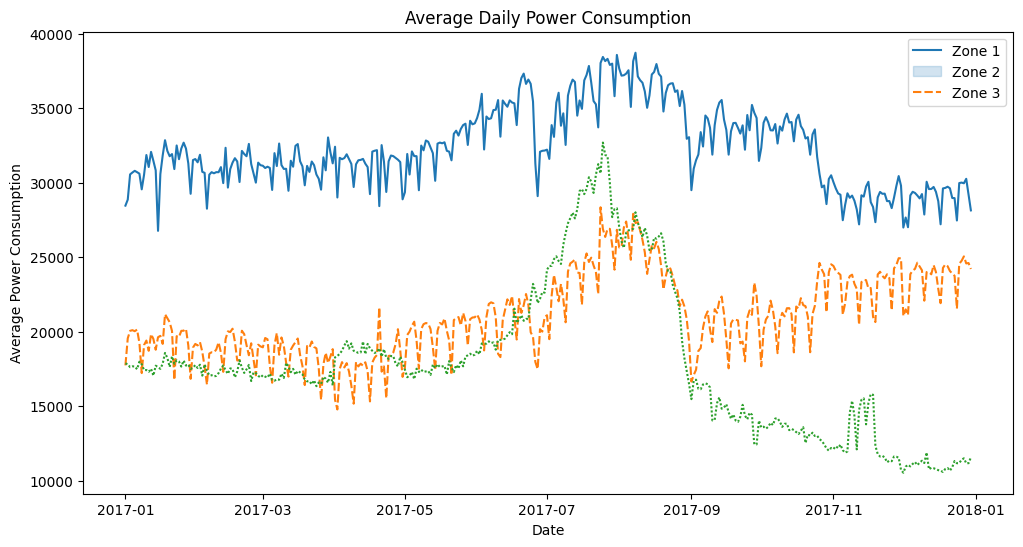

In [11]:
daily_resampled = df.resample('D').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

In [12]:
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)


In [13]:
xgb_model = xgb.XGBRegressor(
    tree_method='hist',
    booster='gbtree',
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=2,
    n_estimators=1000,
    objective='reg:squarederror',
    subsample=0.5
)

In [14]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [15]:
y_pred = xgb_model.predict(X_test)  


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"Mean Squared Error on test set: {mse}")
print(f"Mean Absolute Error on test set: {mae}")

Mean Squared Error on test set: 11560249.119712092
Mean Absolute Error on test set: 2674.181470058061


## Part 2(Saving The Model)

In [16]:
xgb_model.save_model("xgb_model.json")

In [17]:
from dotenv import load_dotenv
import os

load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_SESSION_TOKEN = os.getenv("AWS_SESSION_TOKEN")
REGION = os.getenv("REGION")
KINESIS_STREAM_NAME = os.getenv("KINESIS_STREAM_NAME")


In [20]:
bucket_name = "energiemodel"
s3_file_path = "models/xgb_model.json"

In [21]:
import boto3
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    aws_session_token=AWS_SESSION_TOKEN,  
    region_name=REGION
)

In [22]:
model_path = "xgb_model.json"  

try:
    s3.upload_file(Filename=model_path, Bucket=bucket_name, Key=s3_file_path)
    print(f"Model successfully uploaded to s3://{bucket_name}/{s3_file_path}")
except Exception as e:
    print(f"Error uploading model to S3: {e}")

Model successfully uploaded to s3://energiemodel/models/xgb_model.json


## Part 3(Straming The Data)

In [23]:
kinesis_client = boto3.client(
    "kinesis",
    region_name=REGION,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    aws_session_token=AWS_SESSION_TOKEN
)

In [24]:
import json
import time

def send_records_to_kinesis(dataframe):
    for index, row in dataframe.iterrows():

        row_dict = row.to_dict()
        data_dict = {'Datetime': str(index)}
        data_dict.update(row_dict)
        data = json.dumps(data_dict)
        response = kinesis_client.put_record(
            StreamName=KINESIS_STREAM_NAME,
            Data=data.encode('utf-8'),
            PartitionKey=str(index)
        )
        print(f"Record {index} sent. SequenceNumber: {response['SequenceNumber']}")
        time.sleep(1)  # Adjust as needed

In [ ]:
send_records_to_kinesis(X_test)